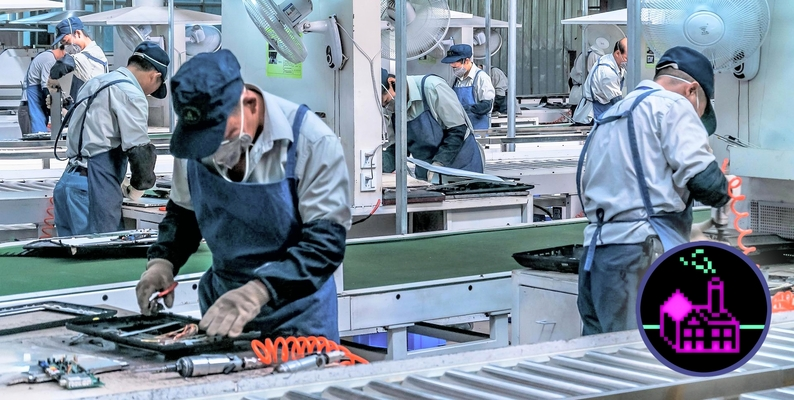

# **1. EDA**
- - -

In [ ]:
# 라이브러리 설치

!pip install category_encoders
!pip install eli5
!pip install PDPbox
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 890 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 14.6 MB/s 
     |████████████████████████████████| 133 kB 68.1 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=5c48d48c19b64f883c11b63ad279a3cedbc8e1edd32973081bfd48bae21f3646
  Stored in directory: /root/.cache/pip/wheels/85/ac/25/ffcd87ef8f9b1eec324fdf339359be71f22612459d8c75d89c
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 5.7.16 r

In [ ]:
# 라이브러리

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
from scipy.stats import randint
from eli5.sklearn import PermutationImportance

from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV

# 회귀 평가
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# 분류 평가
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
import shap
from pdpbox.pdp import pdp_isolate, pdp_plot

In [ ]:
# 데이터 호출

df = pd.read_csv(r'worker.csv', index_col=0) # 'unnamed: 0' 제거
df.shape

(82389, 42)

In [ ]:
# 전처리

# 능률값이 none인 row 제거
df.drop(df[df['recorded_efficacy'] == 'None'].index, inplace=True)

# 불필요한 특성 제거
df.drop([x for x in df.columns[[1, 2, 7, 8, 9, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 34, 35, 37, 38, 39, 40, 41]]], axis=1, inplace=True)

# ID정리
df['sub_ID'] = df['sub_ID'].astype(str).str[-3:]
df['sup_ID'] = df['sup_ID'].astype(str).str[-3:]

# 요일 문자 정리
df['event_weekday_name'] = df['event_weekday_name'].str[:3].str.upper()

# 데이터 타입 변경
df = df.astype({'sub_age' : 'int',
                'sup_age' : 'int',
                'actual_efficacy_h' : 'float'})

# 칼럼명 정리
df.columns = df.columns.str.replace('sub_', '').str.replace('_h', '')

# 인덱스 정리
df.reset_index(drop=True, inplace=True)

# 분류용 타겟
df['efficacy_class'] = df['actual_efficacy'] > df['actual_efficacy'].median()

In [ ]:
df.shape

(38293, 21)

In [ ]:
df.head()

,ID,age,sex,shift,team,health,commitment,perceptiveness,dexterity,sociality,...,strength,openmindedness,workstyle,sup_ID,sup_age,sup_sex,event_day_in_series,event_weekday_name,actual_efficacy,efficacy_class
0,567,61,M,Shift 1,Team 8,0.888,0.578,0.954,0.746,0.568,...,0.879,0.365,Group C,680,59,M,519,FRI,1.045,True
1,437,28,M,Shift 3,Team 21,0.625,0.955,0.555,0.809,0.899,...,0.960,0.718,Group E,021,25,M,223,WED,1.095,True
2,265,51,F,Shift 2,Team 12,0.958,0.610,0.874,0.558,0.892,...,0.594,0.568,Group C,012,53,F,84,THU,1.270,True
3,250,40,F,Shift 2,Team 12,0.732,0.456,0.616,0.920,0.327,...,0.818,0.835,Group D,012,53,F,64,FRI,0.693,True
4,203,41,M,Shift 2,Team 9,0.790,0.922,0.398,0.674,0.979,...,0.785,0.968,Group B,009,28,M,412,WED,0.711,True


# **2. 분석**
- - -

Color Sceme : 


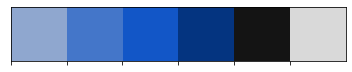

In [ ]:
class clr:
  S = '\033[1m' + '\033[96m'
  E = '\033[0m'

colors = ["#8fa7cf","#4476c9", "#1256c7", "#043480", "#141414", "#d9d9d9"]

print(clr.S + 'Color Sceme :', clr.E)
sns.palplot(sns.color_palette(colors))

## 2-1. 요일, 날짜별

FRI    0.200742
THU    0.200428
TUE    0.200402
WED    0.199540
MON    0.198600
SAT    0.000287
Name: event_weekday_name, dtype: float64


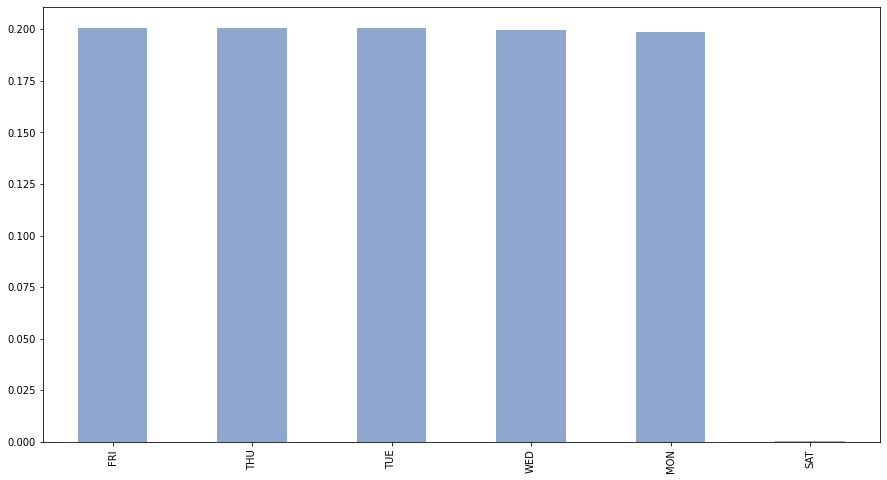

In [ ]:
# 전체 출근요일 비율

print(df['event_weekday_name'].value_counts(normalize=True))

plt.figure(figsize = (15,8))
df['event_weekday_name'].value_counts(normalize=True).plot(kind = 'bar',color = colors[0])
plt.show()

In [ ]:
# efficacy class 요일 비율

day1 = df[df['efficacy_class'] == True]['event_weekday_name'].value_counts(normalize=True)
day2 = df[df['efficacy_class'] == False]['event_weekday_name'].value_counts(normalize=True)

dayt = pd.concat([pd.DataFrame(day2), pd.DataFrame(day1)], axis=1)
dayt.columns = ['low', 'high']
dayt

,low,high
MON,0.240881,0.156247
TUE,0.217659,0.183116
WED,0.199499,0.199582
THU,0.177373,0.223523
FRI,0.164379,0.237167
SAT,0.000209,0.000366


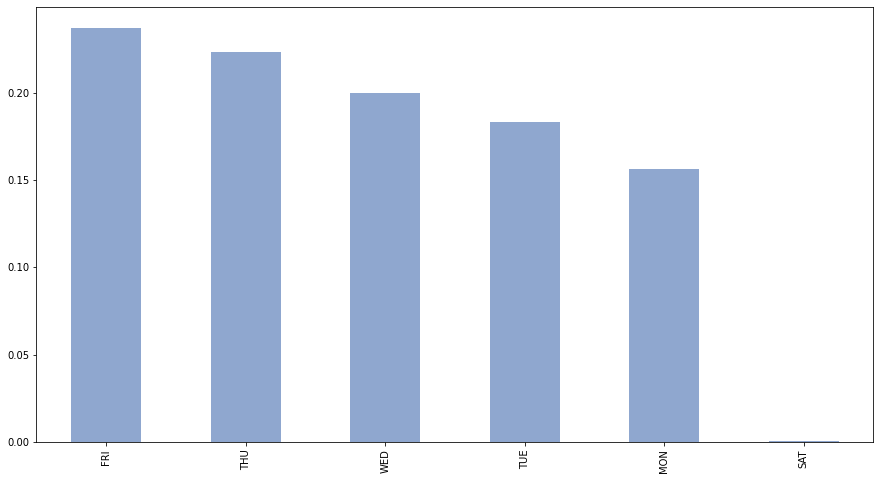

In [ ]:
# efficacy class = high를 받은 요일 비율

plt.figure(figsize = (15,8))
day1.plot(kind = 'bar',color = colors[0])
plt.show()

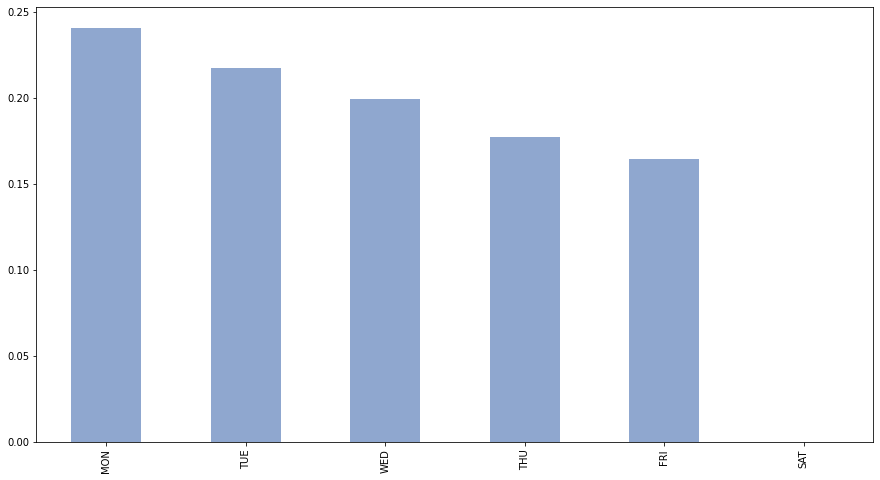

In [ ]:
# efficacy class = low를 받은 요일 비율

plt.figure(figsize= (15,8))
day2.plot(kind = 'bar',color = colors[0])
plt.show()

## 2-2. 모델링

In [ ]:
np.random.seed(42)

train, val = train_test_split(df, train_size=0.8)
train, test = train_test_split(train, train_size=0.8)

In [ ]:
train.shape, val.shape, test.shape

((24507, 21), (7659, 21), (6127, 21))

In [ ]:
# 특성, 타겟 분리(분류)

target = 'efficacy_class'
feature = df.columns.drop([target, 'ID', 'sup_ID', 'actual_efficacy'])

X_train, y_train = train[feature], train[target]
X_val, y_val = val[feature], val[target]
X_test, y_test = test[feature], test[target]

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((24507, 17), (7659, 17), (6127, 17), (24507,), (7659,), (6127,))

In [ ]:
# 기준 모델

y_pred = [train['efficacy_class'].mode()[0]] * len(train['efficacy_class'])
print('Accuracy : ', accuracy_score(y_train, y_pred).round(3))

Accuracy :  0.502


In [ ]:
# 모델링

pipe = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(n_jobs=-1, random_state=42)
)

params ={
    'xgbclassifier__learning_rate' : [0.1, 0.2, 0.3],
    'xgbclassifier__max_depth' : [5, 10, 15],
    'xgbclassifier__n_estimators' : randint(50, 500)
}

clf = RandomizedSearchCV(
    pipe,
    param_distributions = params,
    n_iter=10,
    cv=5,
    scoring='roc_auc',
    verbose=1,
)

clf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('xgbclassifier',
                                              XGBClassifier(n_jobs=-1,
                                                            random_state=42))]),
                   param_distributions={'xgbclassifier__learning_rate': [0.1,
                                                                         0.2,
                                                                         0.3],
                                        'xgbclassifier__max_depth': [5, 10, 15],
                                        'xgbclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd161634910>},
                   scoring='roc_auc', verbose=1)

In [ ]:
print('최적의 하이퍼 파라미터:', clf.best_params_)
print('AUC:', clf.best_score_)

최적의 하이퍼 파라미터: {'xgbclassifier__learning_rate': 0.3, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 59}
AUC: 0.7403961929035016


Accuracy :  0.687
F1 score :  0.688
AUC score :  0.752


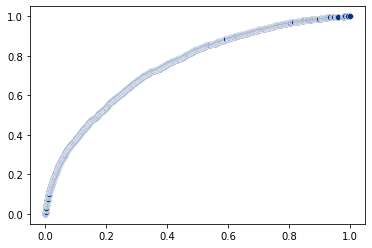

In [ ]:
# 검증 데이터의 auc score

y_pred = clf.predict(X_val)
y_pred_proba = clf.predict_proba(X_val)[:, 1]

fpr, tpr, threshold = roc_curve(y_val, y_pred_proba)
print('Accuracy : ', accuracy_score(y_val, y_pred).round(3))
print('F1 score : ', f1_score(y_val, y_pred).round(3))
print('AUC score : ', roc_auc_score(y_val, y_pred_proba).round(3))

sns.scatterplot(x=fpr, y=tpr, color=colors[3])

Accuracy :  0.677
F1 score :  0.681
AUC score :  0.746


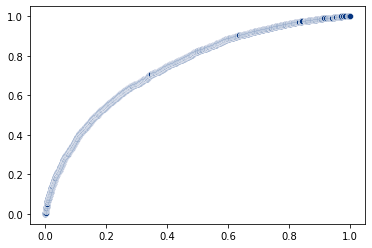

In [ ]:
# 테스트 데이터의 auc score

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)
print('Accuracy : ', accuracy_score(y_test, y_pred).round(3))
print('F1 score : ', f1_score(y_test, y_pred).round(3))
print('AUC score : ', roc_auc_score(y_test, y_pred_proba).round(3))

sns.scatterplot(x=fpr, y=tpr, color=colors[3])

In [ ]:
# 특성 중요도

permuter = PermutationImportance(
    clf,
    scoring='roc_auc',
    n_iter=5,
    random_state=42
)

enc = OrdinalEncoder()
X_train_encoded = enc.fit_transform(X_train)
permuter.fit(X_train_encoded, y_train)

feature_names = X_train.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

age                    0.110621
sup_age                0.086053
event_day_in_series    0.062894
perceptiveness         0.011936
strength               0.009380
dexterity              0.007557
commitment             0.007005
health                 0.006993
sociality              0.006464
goodness               0.005217
openmindedness         0.005067
sex                    0.000000
workstyle              0.000000
team                   0.000000
sup_sex                0.000000
shift                  0.000000
event_weekday_name     0.000000
dtype: float64

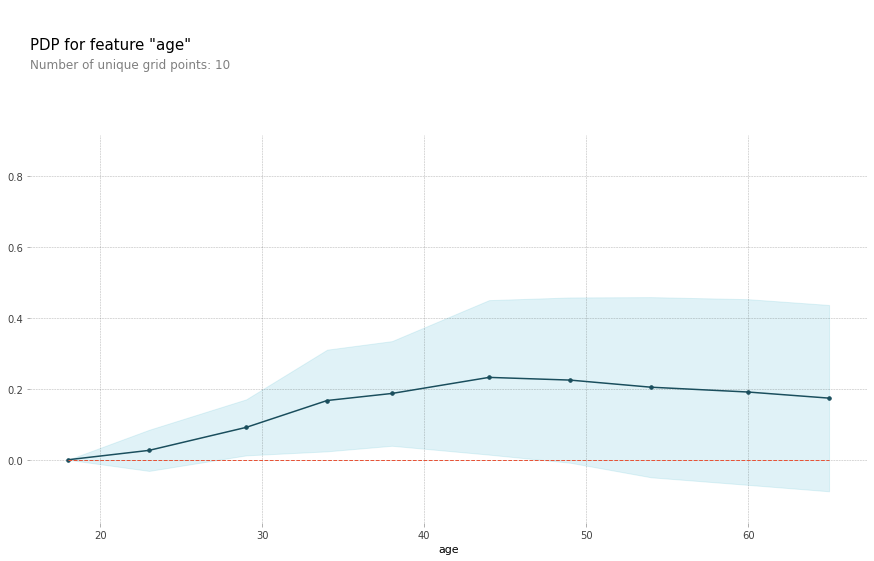

In [ ]:
# pdp

feature = 'age'

isolated = pdp_isolate(
    model = clf,
    dataset = X_train,
    model_features = X_train.columns,
    feature = 'age',
    grid_type='percentile',
    num_grid_points=10
)
pdp_plot(isolated, feature_name = feature);

In [ ]:
# shap

explainer = shap.TreeExplainer(clf.best_estimator_.named_steps['xgbclassifier'])

row = X_train_encoded.iloc[:11]
shap_values = explainer.shap_values(row)
shap.initjs()

shap.force_plot(
    base_value = explainer.expected_value,
    shap_values = shap_values,
    features = row
)

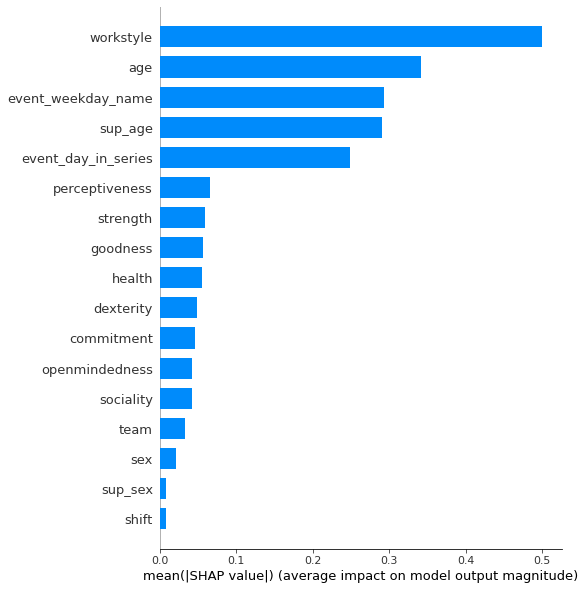

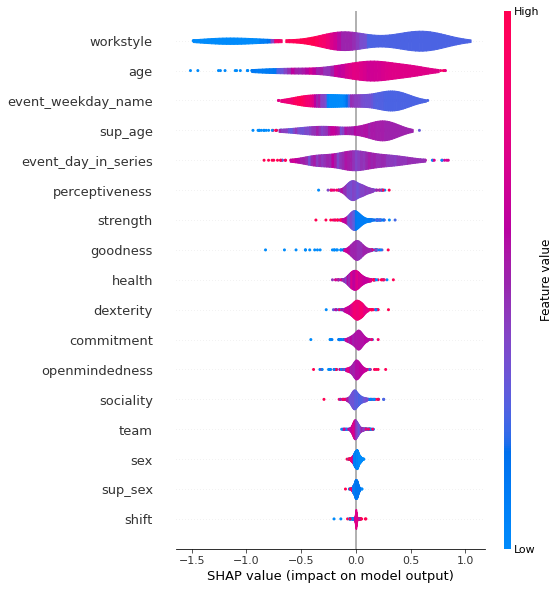

In [ ]:
shap_values = explainer.shap_values(X_train_encoded.iloc[:400])
shap.summary_plot(shap_values, X_train_encoded.iloc[:400], plot_type='bar')
shap.summary_plot(shap_values, X_train_encoded.iloc[:400], plot_type='violin')

## 2-3. 나이별

In [ ]:
# 인부별 데이터

df_stat = df.groupby('ID').mean().drop('event_day_in_series', axis=1)

df_stat = df_stat.astype({'age' : 'int', 'sup_age' : 'int'})

df_stat

,age,health,commitment,perceptiveness,dexterity,sociality,goodness,strength,openmindedness,sup_age,actual_efficacy,efficacy_class
ID,,,,,,,,,,,,
001,40,0.895,1.000,0.659,0.592,0.799,0.501,0.484,0.676,24,0.873470,0.686747
002,61,0.752,0.563,0.449,0.766,0.872,0.655,0.786,0.908,24,0.469750,0.318182
003,20,0.573,0.907,0.735,0.878,0.985,0.840,0.900,0.777,24,0.689260,0.701299
004,18,0.547,0.819,0.659,0.776,0.556,0.755,0.872,0.382,24,0.496915,0.197183
005,59,0.777,0.629,0.678,0.749,0.652,0.686,0.566,0.336,24,0.525873,0.338028
...,...,...,...,...,...,...,...,...,...,...,...,...
784,23,0.677,0.993,0.599,0.694,0.765,0.630,0.660,0.648,40,0.616333,0.500000
785,57,0.713,0.705,0.779,0.949,0.843,0.563,0.692,0.780,53,1.127600,1.000000
786,30,0.905,0.704,0.878,0.786,0.925,0.548,0.755,0.704,59,0.742667,0.333333


In [ ]:
# 데이터셋 분리

np.random.seed(42)

train, val = train_test_split(df_stat, train_size=0.8)
train, test = train_test_split(train, train_size=0.8)

train.shape, val.shape, test.shape

((434, 12), (136, 12), (109, 12))

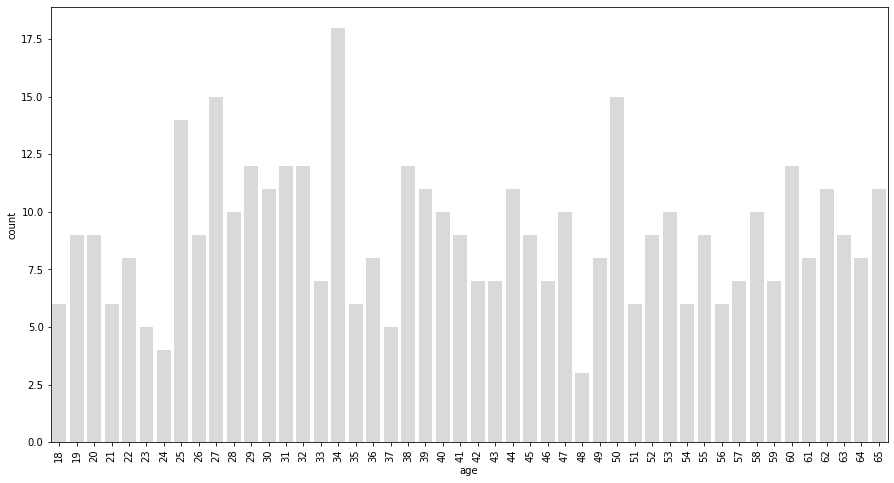

In [ ]:
# 연령별 인구수

plt.figure(figsize=(15,8))

sns.countplot(x=train['age'], color=colors[5])
plt.xticks(rotation=90);

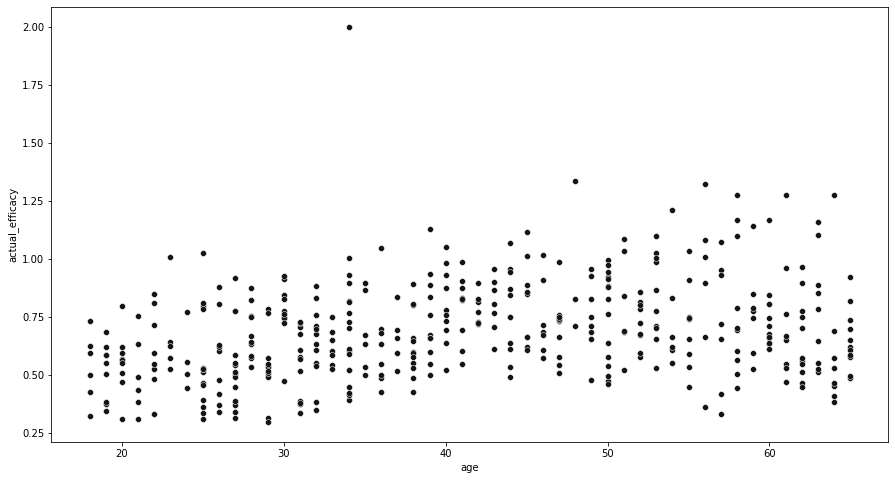

In [ ]:
# 

plt.figure(figsize=(15,8))

sns.scatterplot(x=train['age'], y=train['actual_efficacy'], color=colors[4]);

MSE : 0.04
MAE : 0.16
R2 : -0.0119


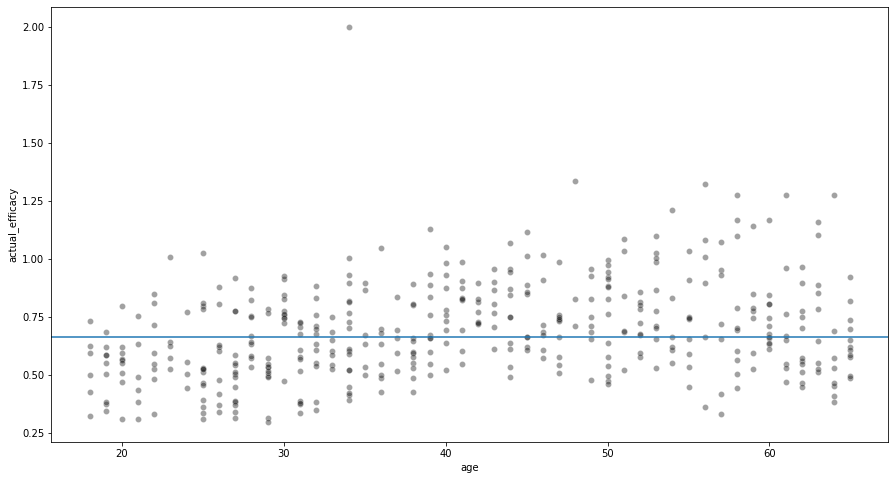

In [ ]:
# 기준모델

plt.figure(figsize=(15,8))

y_pred = [train['actual_efficacy'].median()] * len(train['actual_efficacy'])
print('MSE : {:.2f}'.format(mean_squared_error(train['actual_efficacy'], y_pred)))
print('MAE : {:.2f}'.format(mean_absolute_error(train['actual_efficacy'], y_pred)))
print('R2 : {:.4f}'.format(r2_score(train['actual_efficacy'], y_pred)))

sns.scatterplot(x=train['age'], y=train['actual_efficacy'], color=colors[4], alpha=0.4);
plt.axhline(train['actual_efficacy'].median()); # 기준 모델

In [ ]:
# 기준모델 정확도

y_pred = [train['actual_efficacy'].median()] * len(train['actual_efficacy'])
print('MSE : {:.2f}'.format(mean_squared_error(train['actual_efficacy'], y_pred)))
print('MAE : {:.2f}'.format(mean_absolute_error(train['actual_efficacy'], y_pred)))

MSE : 0.04
MAE : 0.16


MSE : 0.0371
MAE : 0.1494
R2 : 0.1493


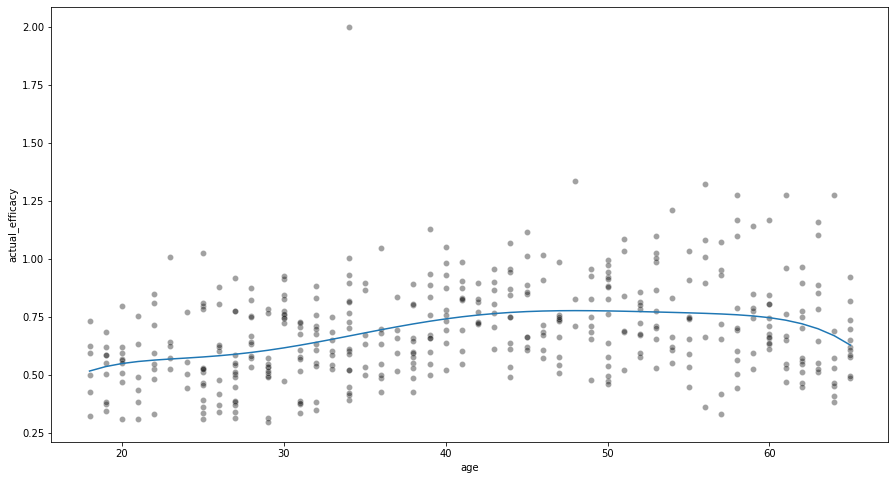

In [ ]:
# 다항회귀선 모델링

x = np.array(train['age'])[:, np.newaxis]
y = np.array(train['actual_efficacy'])

linear = LinearRegression()

quad = PolynomialFeatures(degree=6) # n=6일 때 검증최적
x_quad = quad.fit_transform(x)

x_fit = np.arange(18, 66, 1)[:, np.newaxis]

linear.fit(x_quad, y)
y_quad_fit = linear.predict(quad.fit_transform(x_fit))
y_quad_pred = linear.predict(x_quad)

mse = mean_squared_error(y, y_quad_pred)
mae = mean_absolute_error(y, y_quad_pred)
r2 = r2_score(y, y_quad_pred)

print('MSE : {:.4f}'.format(mse))
print('MAE : {:.4f}'.format(mae))
print('R2 : {:.4f}'.format(r2))

plt.figure(figsize=(15,8))
sns.scatterplot(x=train['age'], y=train['actual_efficacy'], color=colors[4], alpha=0.4);
plt.plot(x_fit, y_quad_fit)

MSE : 0.0375
MAE : 0.1571
R2 : 0.0284


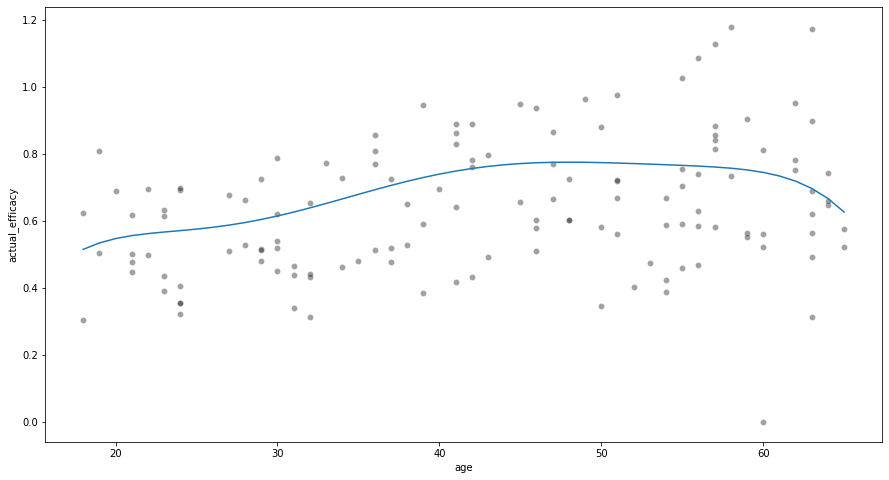

In [ ]:
# 검증 데이터 정확도

x_val = np.array(val['age'])[:, np.newaxis] # feature
y_val = np.array(val['actual_efficacy']) # target

x_quad_val = quad.transform(x_val)

y_quad_val = linear.predict(quad.transform(x_fit))
y_quad_pred_val = linear.predict(x_quad_val)

mse = mean_squared_error(y_val, y_quad_pred_val)
mae = mean_absolute_error(y_val, y_quad_pred_val)
r2 = r2_score(y_val, y_quad_pred_val)

print('MSE : {:.4f}'.format(mse))
print('MAE : {:.4f}'.format(mae))
print('R2 : {:.4f}'.format(r2))

plt.figure(figsize=(15,8))
sns.scatterplot(x=val['age'], y=val['actual_efficacy'], color=colors[4], alpha=0.4);
plt.plot(x_fit, y_quad_val)

MSE : 0.0281
MAE : 0.1401
R2 : 0.1271


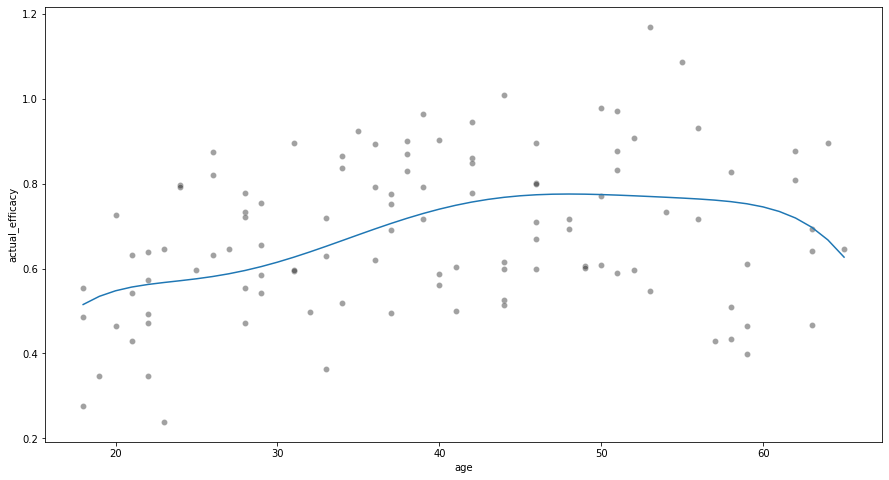

In [ ]:
# 테스트 데이터 정확도

x_test = np.array(test['age'])[:, np.newaxis] # feature
y_test = np.array(test['actual_efficacy']) # target

x_quad_test = quad.transform(x_test)

y_quad_test = linear.predict(quad.transform(x_fit))
y_quad_pred_test = linear.predict(x_quad_test)

mse = mean_squared_error(y_test, y_quad_pred_test)
mae = mean_absolute_error(y_test, y_quad_pred_test)
r2 = r2_score(y_test, y_quad_pred_test)

print('MSE : {:.4f}'.format(mse))
print('MAE : {:.4f}'.format(mae))
print('R2 : {:.4f}'.format(r2))

plt.figure(figsize=(15,8))
sns.scatterplot(x=test['age'], y=test['actual_efficacy'], color=colors[4], alpha=0.4);
plt.plot(x_fit, y_quad_test)